<a href="https://colab.research.google.com/github/harshkrr/Support-Vector-Regression/blob/main/SVR_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from google.colab import files

In [2]:
uploaded = files.upload()

Saving SVM_DATA.csv to SVM_DATA.csv


In [3]:
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

User uploaded file "SVM_DATA.csv" with length 51145 bytes


In [4]:
# uploaded

In [5]:
import io

In [6]:
df= pd.read_csv(io.StringIO(uploaded['SVM_DATA.csv'].decode('utf-8')))

In [7]:
df = np.array(df)

In [8]:
data = []

In [9]:
for i in range(0, len(df), 2):
    row = []
    temp1 = df[i][0].split()
    temp2 = df[i+1][0].split()
    for t in temp1:
        row.append(float(t))
    for t in temp2:
        row.append(float(t))
        
    row = np.array(row)
    data.append(row)
    

In [10]:
# data[0]

In [11]:
# normalisation of data
data = np.array(data)
data -= np.mean(data, axis=0)
data /= np.std(data, axis=0)

In [12]:
# data[0]

In [13]:
# data.shape

In [14]:
from sklearn.svm import SVR
import matplotlib.pyplot as plt

from numpy import linalg as LA
import math

from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers

In [15]:
# define the Kernal Function for it is RBF
def kernal_rbf(x, y, gamma):
  k = math.exp((-1)*gamma*(LA.norm(x-y)*(LA.norm(x-y))))
  return k

In [17]:
n = 5
temp1 = np.ones(2*n)
temp2 = np.ones(2*n);
h = np.concatenate((temp1, temp2))
h

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

In [18]:
def kernal_matrix_rbf(X, gamma):
  n = len(X);
  k = np.zeros([n, n])
  for i in range(len(X)):
    for j in range(len(X)):
      k[i][j] = kernal_rbf(X[i], X[j], gamma)
  return k

In [19]:
def b_term_rbf(x, n, lamda_1, lamda_2, x_train, gamma):
  total = 0;
  for i in range(n):
    total = total+(lamda_1[i][0]-lamda_2[i][0])*kernal_rbf(x, x_train[i], gamma)
  return total

In [20]:
# define the polynomial kernal function, d id the degree of freedom pf polynomial and cons is the constant term
def kernal_polynomial(x, y, constant, d):
  k = pow(np.dot(x, y)+constant, d)
  return k

In [21]:
def kernal_matrix_polynomial(X, constant, d):
  n = len(X);
  k = np.zeros([n, n])
  for i in range(len(X)):
    for j in range(len(X)):
      k[i][j] = kernal_polynomial(X[i], X[j], constant, d)
  return k

In [22]:
def b_term_polynomial(x, n, lamda_1, lamda_2, x_train, constant, d):
  total = 0;
  for i in range(n):
    total = total+(lamda_1[i][0]-lamda_2[i][0])*kernal_polynomial(x, x_train[i], constant, d)
  return total

In [23]:
# define a linear kernal function
def kernal_linear(x, y, cons):
  k = np.dot(x, y)+cons
  return k

In [24]:
def kernal_matrix_linear(X, cons):
  n = len(X);
  k = np.zeros([n, n])
  for i in range(len(X)):
    for j in range(len(X)):
      k[i][j] = kernal_linear(X[i], X[j], cons)
  return k

In [25]:
def b_term_linear(x, n, lamda_1, lamda_2, x_train, cons):
  total = 0;
  for i in range(n):
    total = total+(lamda_1[i][0]-lamda_2[i][0])*kernal_linear(x, x_train[i], cons)
  return total

In [27]:
# calculate P matrix for rbf
def P_Matrix_rbf(X, gamma):
  k = kernal_matrix_rbf(X,gamma)
  neg_k = (-1)*k
  temp1 = np.concatenate((k, neg_k))
  temp2 = np.concatenate((neg_k, k))
  P = np.concatenate((temp1, temp2), axis = 1)
  return P

In [28]:
# calculate P matrix for linear
def P_Matrix_linear(X, cons):
  k = kernal_matrix_linear(X, cons)
  neg_k = (-1)*k
  temp1 = np.concatenate((k, neg_k))
  temp2 = np.concatenate((neg_k, k))
  P = np.concatenate((temp1, temp2), axis = 1)
  return P

In [29]:
# calculate P matrix for polynomial
def P_Matrix_polynomial(X, constant, d):
  k = kernal_matrix_polynomial(X, constant, d)
  neg_k = (-1)*k
  temp1 = np.concatenate((k, neg_k))
  temp2 = np.concatenate((neg_k, k))
  P = np.concatenate((temp1, temp2), axis = 1)
  return P

In [30]:
# calculate q matrix
def q_matrix(y, elp):
  temp1 = -y+elp
  temp2 = y+elp
  q = np.concatenate((temp1, temp2))
  return q

In [31]:
# calculate G matrix
def G_matrix(n):
  temp1 = np.identity(2*n)
  temp2 = (-1.0)*temp1
  g = np.concatenate((temp1, temp2))
  return g

In [32]:
# calculate h matrix
def h_matrix(C, n):
  temp1 = np.ones(2*n)
  temp2 = np.zeros(2*n)
  h = np.concatenate((temp1, temp2))
  return h

In [33]:
# calculate A matrix
def A_matrix(n):
  temp1 = np.ones(n)
  temp2 = (-1.0)*temp1
  temp = np.concatenate((temp1, temp2))
  temp = temp.reshape(1,-1)
  return temp

In [34]:
# calculate b matrix
def b_matrix():
  b = np.zeros(1)
  return b

In [35]:
# define the hyper parameters
C = 100
gamma = 0.1
elp = 0.1

In [37]:
# prediction of y for rbf
def Y_predicted_rbf(X, n, lamda_1, lamda_2, X_train, b, gamma):
  total = 0
  for i in range(n):
    total = total+(lamda_1[i][0]-lamda_2[i][0])*kernal_rbf(X, X_train[i], gamma)
  y = total+b
  return y

In [38]:
# prediction of y for linear
def Y_predicted_linear(X, n, lamda_1, lamda_2, X_train, b, cons):
  total = 0
  for i in range(n):
    total = total+(lamda_1[i][0]-lamda_2[i][0])*kernal_linear(X, X_train[i], cons)
  y = total+b
  return y

In [39]:
# prediction of y for polynomial
def Y_predicted_polynomial(X, n, lamda_1, lamda_2, X_train, b, constant, d):
  total = 0
  for i in range(n):
    total = total+(lamda_1[i][0]-lamda_2[i][0])*kernal_polynomial(X, X_train[i], constant, d)
  y = total+b
  return y

In [40]:
# calculation of Math square Error
def MSE(Y_predict, Y_test, elp):
  total = 0
  for i in range(len(Y_test)):
    total = total + (abs(Y_predict[i]-Y_test[i])-elp)*(abs(Y_predict[i]-Y_test[i])-elp)
  error = total/(len(Y_test))
  return error

In [41]:
# array that will store error in each fold
score_rbf = [];

     pcost       dcost       gap    pres   dres
 0: -3.1323e+01 -1.8066e+03  8e+03  2e+00  1e-14
 1: -6.2912e+00 -1.1012e+03  1e+03  2e-13  2e-14
 2: -2.4806e+01 -1.5552e+02  1e+02  2e-13  2e-14
 3: -5.6235e+01 -8.6301e+01  3e+01  1e-13  1e-14
 4: -6.7796e+01 -7.4964e+01  7e+00  7e-14  1e-14
 5: -7.0263e+01 -7.1880e+01  2e+00  9e-14  1e-14
 6: -7.0900e+01 -7.1106e+01  2e-01  6e-14  1e-14
 7: -7.0982e+01 -7.1004e+01  2e-02  1e-14  1e-14
 8: -7.0991e+01 -7.0992e+01  8e-04  9e-14  1e-14
 9: -7.0992e+01 -7.0992e+01  2e-05  5e-14  1e-14
Optimal solution found.


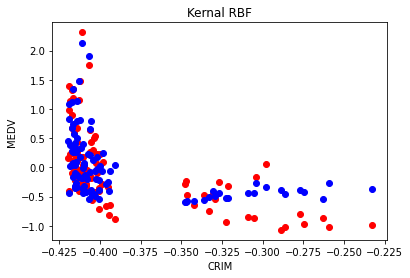

     pcost       dcost       gap    pres   dres
 0: -2.4548e+01 -1.8043e+03  8e+03  2e+00  2e-14
 1: -9.2433e-01 -1.0986e+03  1e+03  6e-14  2e-14
 2: -1.8125e+01 -1.4270e+02  1e+02  6e-14  2e-14
 3: -4.9311e+01 -7.7967e+01  3e+01  4e-14  2e-14
 4: -6.0151e+01 -6.7225e+01  7e+00  7e-14  1e-14
 5: -6.2960e+01 -6.4130e+01  1e+00  2e-14  1e-14
 6: -6.3433e+01 -6.3619e+01  2e-01  6e-14  1e-14
 7: -6.3516e+01 -6.3528e+01  1e-02  7e-14  1e-14
 8: -6.3522e+01 -6.3522e+01  4e-04  2e-16  1e-14
 9: -6.3522e+01 -6.3522e+01  9e-06  1e-13  1e-14
Optimal solution found.


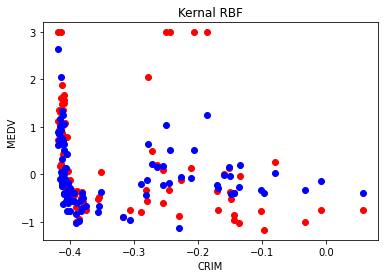

     pcost       dcost       gap    pres   dres
 0: -2.6646e+01 -1.7966e+03  8e+03  2e+00  2e-14
 1: -1.2419e+00 -1.0918e+03  1e+03  2e-13  3e-14
 2: -1.9441e+01 -1.4386e+02  1e+02  1e-14  2e-14
 3: -5.0883e+01 -7.9522e+01  3e+01  5e-15  2e-14
 4: -6.1804e+01 -6.8789e+01  7e+00  2e-14  2e-14
 5: -6.4447e+01 -6.5970e+01  2e+00  1e-14  1e-14
 6: -6.5025e+01 -6.5334e+01  3e-01  1e-14  1e-14
 7: -6.5146e+01 -6.5197e+01  5e-02  9e-14  1e-14
 8: -6.5168e+01 -6.5173e+01  4e-03  8e-15  1e-14
 9: -6.5170e+01 -6.5170e+01  2e-04  2e-14  1e-14
10: -6.5170e+01 -6.5170e+01  4e-06  4e-14  1e-14
Optimal solution found.


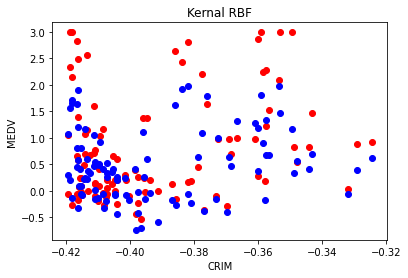

     pcost       dcost       gap    pres   dres
 0: -1.2221e+01 -1.2719e+03  4e+03  2e+00  1e-14
 1: -1.8402e+00 -6.1261e+02  6e+02  1e-13  2e-14
 2: -2.2770e+01 -1.0309e+02  8e+01  6e-14  2e-14
 3: -4.8901e+01 -6.7475e+01  2e+01  8e-14  1e-14
 4: -5.5754e+01 -6.0159e+01  4e+00  7e-14  1e-14
 5: -5.7409e+01 -5.8392e+01  1e+00  2e-14  1e-14
 6: -5.7789e+01 -5.7956e+01  2e-01  3e-14  1e-14
 7: -5.7860e+01 -5.7874e+01  1e-02  4e-14  1e-14
 8: -5.7867e+01 -5.7867e+01  3e-04  7e-14  1e-14
 9: -5.7867e+01 -5.7867e+01  7e-06  4e-14  1e-14
Optimal solution found.


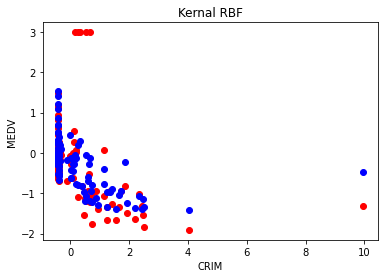

     pcost       dcost       gap    pres   dres
 0: -2.6203e+01 -1.7530e+03  8e+03  2e+00  2e-14
 1: -2.9406e+00 -1.0530e+03  1e+03  7e-14  2e-14
 2: -2.1084e+01 -1.5810e+02  1e+02  9e-14  2e-14
 3: -5.1241e+01 -8.2328e+01  3e+01  2e-14  2e-14
 4: -6.3098e+01 -7.0283e+01  7e+00  5e-14  1e-14
 5: -6.5639e+01 -6.7373e+01  2e+00  4e-14  1e-14
 6: -6.6320e+01 -6.6562e+01  2e-01  8e-14  1e-14
 7: -6.6420e+01 -6.6444e+01  2e-02  5e-15  1e-14
 8: -6.6431e+01 -6.6432e+01  1e-03  7e-14  1e-14
 9: -6.6431e+01 -6.6431e+01  3e-05  4e-14  1e-14
Optimal solution found.


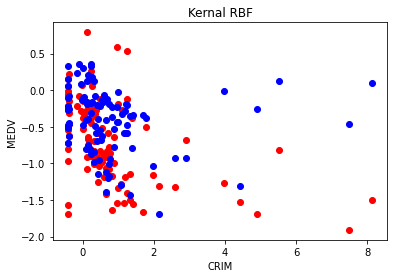

0.2984511210560963


In [50]:
k_fold_size = 101 # 5-cross validation
no_of_fold = int(len(data)/k_fold_size)
for i in range(no_of_fold):
  X_test = np.array([data[j][:-1] for j in range(i*k_fold_size,(i+1)*k_fold_size)])
  Y_test = np.array([data[j][-1] for j in range(i*k_fold_size,(i+1)*k_fold_size)])

  X_train = []
  Y_train = []
  for j in range(len(data)):
      if (j<i*k_fold_size) or (j>=(i+1)*k_fold_size):
          X_train.append(data[j][:-1])
          Y_train.append(data[j][-1])
  X_train = np.array(X_train)
  Y_train = np.array(Y_train)

  n = len(X_train)
  P = P_Matrix_rbf(X_train, gamma)
  q = q_matrix(Y_train, elp)
  G = G_matrix(n)
  h = h_matrix(C, n)
  A = A_matrix(n)
  b = b_matrix()

  # print("n"+str(n))
  # print("P"+str(P.shape))
  # print("q"+str(q.shape))
  # print("G"+str(G.shape))
  # print("h"+str(h.shape))
  # print("A"+str(A.shape))
  # print("b"+str(b.shape))

  P = cvxopt_matrix(P)
  q = cvxopt_matrix(q)
  G = cvxopt_matrix(G)
  h = cvxopt_matrix(h)
  A = cvxopt_matrix(A)
  b = cvxopt_matrix(b)

  sol = cvxopt_solvers.qp(P, q, G, h, A, b)
  lamda = np.array(sol['x'])
  l = int(len(lamda)/2)
  lamda_1 = lamda[0:l, :]
  lamda_2 = lamda[l:,:]
  # print(lamda_1[1][0])
  # print(lamda_1.shape)
  # print(lamda_2.shape)

  # the supp_vector array will contain all indics of vectors which are support vectors
  supp_vector = []
  for j in range(len(lamda_1)):
    temp = lamda_1[j][0]
    if temp>0 and temp<C:
      supp_vector.append(j)

  # calculation of b
  b = 0
  for i in supp_vector:
    b = b+Y_train[i]-elp-b_term_rbf(X_train[i], n, lamda_1, lamda_2, X_train, gamma)
  b = b/(len(supp_vector))

  Y_predict_rbf = []
  for i in range(len(X_test)):
    temp_i = Y_predicted_rbf(X_test[i], n, lamda_1, lamda_2, X_train, b, gamma)
    Y_predict_rbf.append(temp_i)
  Y_predict_rbf = np.array(Y_predict_rbf)
  # print(Y_predict[0])
  # print(Y_test)
  
  error = MSE(Y_predict_rbf, Y_test, elp)
  score_rbf.append(error)

  plt.title('Kernal RBF')
  plt.xlabel('CRIM')
  plt.ylabel('MEDV')
  plt.scatter(X_test[:,0], Y_test, color = 'r', label="Y_test".format('r'))
  plt.scatter(X_test[:,0], Y_predict_rbf, color = 'b',label="Y_predicted".format('y'))
  plt.show()

score_final_rbf = 0;
for i in range(len(score_rbf)):
  score_final_rbf = score_final_rbf + score_rbf[i]
score_final_rbf = score_final_rbf/len(score_rbf)
print(score_final_rbf)

In [43]:
score_linear = []
cons = 1

     pcost       dcost       gap    pres   dres
 0: -8.1612e+01 -1.8924e+03  9e+03  3e+00  4e-13
 1: -1.0110e+01 -1.1939e+03  1e+03  7e-15  5e-13
 2: -4.5897e+01 -1.9427e+02  1e+02  5e-14  5e-13
 3: -9.1974e+01 -1.3353e+02  4e+01  4e-14  5e-13
 4: -1.0579e+02 -1.1933e+02  1e+01  3e-14  4e-13
 5: -1.1028e+02 -1.1479e+02  5e+00  2e-14  4e-13
 6: -1.1176e+02 -1.1326e+02  1e+00  1e-14  4e-13
 7: -1.1228e+02 -1.1274e+02  5e-01  2e-13  4e-13
 8: -1.1245e+02 -1.1257e+02  1e-01  7e-14  4e-13
 9: -1.1250e+02 -1.1252e+02  3e-02  8e-14  4e-13
10: -1.1251e+02 -1.1251e+02  2e-03  1e-14  4e-13
11: -1.1251e+02 -1.1251e+02  3e-05  1e-13  5e-13
Optimal solution found.


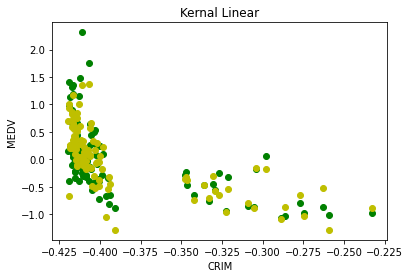

     pcost       dcost       gap    pres   dres
 0: -7.0953e+01 -1.9003e+03  9e+03  3e+00  5e-13
 1: -5.4658e+00 -1.1998e+03  1e+03  3e-14  7e-13
 2: -3.8091e+01 -1.9042e+02  2e+02  2e-13  7e-13
 3: -7.8798e+01 -1.3100e+02  5e+01  1e-13  6e-13
 4: -9.6208e+01 -1.0945e+02  1e+01  5e-14  5e-13
 5: -1.0061e+02 -1.0506e+02  4e+00  3e-15  5e-13
 6: -1.0204e+02 -1.0355e+02  2e+00  1e-13  5e-13
 7: -1.0255e+02 -1.0301e+02  5e-01  7e-14  5e-13
 8: -1.0268e+02 -1.0287e+02  2e-01  2e-14  6e-13
 9: -1.0275e+02 -1.0279e+02  4e-02  5e-14  6e-13
10: -1.0277e+02 -1.0278e+02  8e-03  4e-14  6e-13
11: -1.0277e+02 -1.0277e+02  4e-04  1e-13  6e-13
12: -1.0277e+02 -1.0277e+02  4e-06  5e-14  6e-13
Optimal solution found.


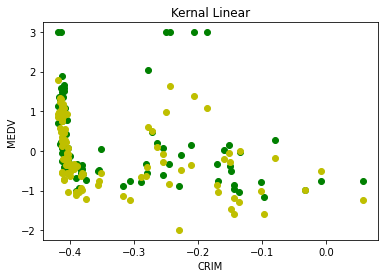

     pcost       dcost       gap    pres   dres
 0: -6.5043e+01 -1.9050e+03  9e+03  3e+00  4e-13
 1: -3.1221e+00 -1.2034e+03  1e+03  6e-14  6e-13
 2: -3.4342e+01 -1.7959e+02  1e+02  2e-13  6e-13
 3: -7.2076e+01 -1.2462e+02  5e+01  7e-14  5e-13
 4: -8.7302e+01 -1.0496e+02  2e+01  1e-15  4e-13
 5: -9.1937e+01 -9.9696e+01  8e+00  1e-13  4e-13
 6: -9.4310e+01 -9.6981e+01  3e+00  9e-14  5e-13
 7: -9.5065e+01 -9.6131e+01  1e+00  3e-14  4e-13
 8: -9.5416e+01 -9.5736e+01  3e-01  7e-14  5e-13
 9: -9.5503e+01 -9.5640e+01  1e-01  2e-14  4e-13
10: -9.5536e+01 -9.5604e+01  7e-02  1e-13  4e-13
11: -9.5560e+01 -9.5578e+01  2e-02  1e-13  5e-13
12: -9.5567e+01 -9.5570e+01  2e-03  7e-14  5e-13
13: -9.5568e+01 -9.5568e+01  4e-05  7e-14  6e-13
Optimal solution found.


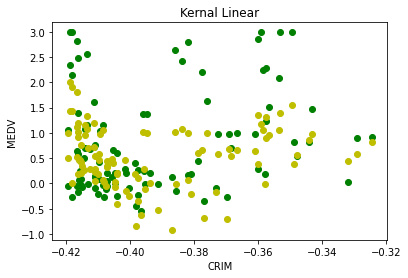

     pcost       dcost       gap    pres   dres
 0: -2.5919e+01 -1.5905e+03  6e+03  2e+00  2e-13
 1:  5.8300e+00 -9.0571e+02  9e+02  1e-15  3e-13
 2: -2.5789e+01 -1.3851e+02  1e+02  8e-14  3e-13
 3: -6.4085e+01 -9.8065e+01  3e+01  5e-14  3e-13
 4: -7.5292e+01 -8.8688e+01  1e+01  1e-13  3e-13
 5: -8.0353e+01 -8.4085e+01  4e+00  4e-14  2e-13
 6: -8.1604e+01 -8.3012e+01  1e+00  6e-14  2e-13
 7: -8.2051e+01 -8.2591e+01  5e-01  8e-14  2e-13
 8: -8.2256e+01 -8.2396e+01  1e-01  2e-14  2e-13
 9: -8.2302e+01 -8.2349e+01  5e-02  4e-14  2e-13
10: -8.2315e+01 -8.2337e+01  2e-02  1e-14  2e-13
11: -8.2321e+01 -8.2331e+01  1e-02  1e-13  2e-13
12: -8.2326e+01 -8.2326e+01  4e-04  1e-13  2e-13
13: -8.2326e+01 -8.2326e+01  4e-06  6e-14  3e-13
Optimal solution found.


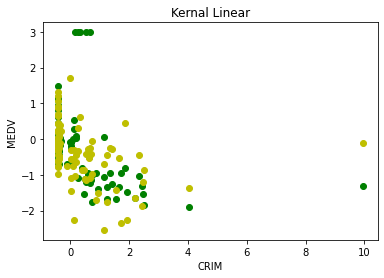

     pcost       dcost       gap    pres   dres
 0: -7.4137e+01 -1.9365e+03  1e+04  3e+00  2e-13
 1: -5.7646e+00 -1.2341e+03  1e+03  8e-14  2e-13
 2: -3.6153e+01 -2.2036e+02  2e+02  1e-13  2e-13
 3: -7.8925e+01 -1.2368e+02  4e+01  3e-13  2e-13
 4: -9.4635e+01 -1.0554e+02  1e+01  4e-14  2e-13
 5: -9.7511e+01 -1.0244e+02  5e+00  1e-13  2e-13
 6: -9.9142e+01 -1.0065e+02  2e+00  3e-14  2e-13
 7: -9.9676e+01 -1.0008e+02  4e-01  2e-14  2e-13
 8: -9.9807e+01 -9.9934e+01  1e-01  2e-14  2e-13
 9: -9.9856e+01 -9.9882e+01  3e-02  3e-14  2e-13
10: -9.9868e+01 -9.9869e+01  9e-04  4e-14  2e-13
11: -9.9869e+01 -9.9869e+01  1e-05  2e-13  2e-13
Optimal solution found.


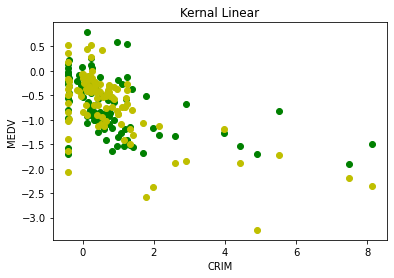

0.33464579604668093


In [49]:
k_fold_size = 101 # 5-cross validation
no_of_fold = int(len(data)/k_fold_size)
for i in range(no_of_fold):
  X_test = np.array([data[j][:-1] for j in range(i*k_fold_size,(i+1)*k_fold_size)])
  Y_test = np.array([data[j][-1] for j in range(i*k_fold_size,(i+1)*k_fold_size)])

  X_train = []
  Y_train = []
  for j in range(len(data)):
      if (j<i*k_fold_size) or (j>=(i+1)*k_fold_size):
          X_train.append(data[j][:-1])
          Y_train.append(data[j][-1])
  X_train = np.array(X_train)
  Y_train = np.array(Y_train)

  n = len(X_train)
  P = P_Matrix_linear(X_train, cons)
  q = q_matrix(Y_train, elp)
  G = G_matrix(n)
  h = h_matrix(C, n)
  A = A_matrix(n)
  b = b_matrix()

  # print("n"+str(n))
  # print("P"+str(P.shape))
  # print("q"+str(q.shape))
  # print("G"+str(G.shape))
  # print("h"+str(h.shape))
  # print("A"+str(A.shape))
  # print("b"+str(b.shape))

  P = cvxopt_matrix(P)
  q = cvxopt_matrix(q)
  G = cvxopt_matrix(G)
  h = cvxopt_matrix(h)
  A = cvxopt_matrix(A)
  b = cvxopt_matrix(b)

  sol = cvxopt_solvers.qp(P, q, G, h, A, b)
  lamda = np.array(sol['x'])
  l = int(len(lamda)/2)
  lamda_1 = lamda[0:l, :]
  lamda_2 = lamda[l:,:]
  # print(lamda_1[1][0])
  # print(lamda_1.shape)
  # print(lamda_2.shape)

  # the supp_vector array will contain all indics of vectors which are support vectors
  supp_vector = []
  for j in range(len(lamda_1)):
    temp = lamda_1[j][0]
    if temp>0 and temp<C:
      supp_vector.append(j)

  # calculation of b
  b = 0
  for i in supp_vector:
    b = b+Y_train[i]-elp-b_term_linear(X_train[i], n, lamda_1, lamda_2, X_train, cons)
  b = b/(len(supp_vector))

  Y_predict_linear = []
  for i in range(len(X_test)):
    temp_i = Y_predicted_linear(X_test[i], n, lamda_1, lamda_2, X_train, b, cons)
    Y_predict_linear.append(temp_i)
  Y_predict_linear = np.array(Y_predict_linear)
  # print(Y_predict[0])
  # print(Y_test)
  
  error = MSE(Y_predict_linear, Y_test, elp)
  score_linear.append(error)

  plt.title('Kernal Linear')
  plt.xlabel('CRIM')
  plt.ylabel('MEDV')
  plt.scatter(X_test[:,0], Y_test, color = 'g', label="Y_test".format('r'))
  plt.scatter(X_test[:,0], Y_predict_linear, color = 'y',label="Y_predicted".format('y'))
  plt.show()

score_final_linear = 0;
for i in range(len(score_linear)):
  score_final_linear = score_final_linear + score_linear[i]
score_final_linear = score_final_linear/len(score_linear)
print(score_final_linear)

In [45]:
score_polynomial = []
constant = 1
d = 1

     pcost       dcost       gap    pres   dres
 0: -8.1612e+01 -1.8924e+03  9e+03  3e+00  4e-13
 1: -1.0110e+01 -1.1939e+03  1e+03  7e-15  5e-13
 2: -4.5897e+01 -1.9427e+02  1e+02  5e-14  5e-13
 3: -9.1974e+01 -1.3353e+02  4e+01  4e-14  5e-13
 4: -1.0579e+02 -1.1933e+02  1e+01  3e-14  4e-13
 5: -1.1028e+02 -1.1479e+02  5e+00  2e-14  4e-13
 6: -1.1176e+02 -1.1326e+02  1e+00  1e-14  4e-13
 7: -1.1228e+02 -1.1274e+02  5e-01  2e-13  4e-13
 8: -1.1245e+02 -1.1257e+02  1e-01  7e-14  4e-13
 9: -1.1250e+02 -1.1252e+02  3e-02  8e-14  4e-13
10: -1.1251e+02 -1.1251e+02  2e-03  1e-14  4e-13
11: -1.1251e+02 -1.1251e+02  3e-05  1e-13  5e-13
Optimal solution found.


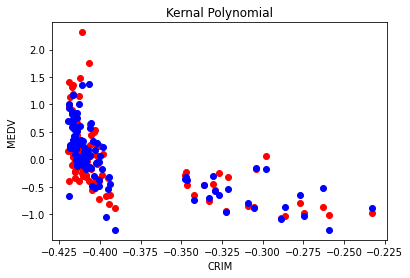

     pcost       dcost       gap    pres   dres
 0: -7.0953e+01 -1.9003e+03  9e+03  3e+00  5e-13
 1: -5.4658e+00 -1.1998e+03  1e+03  3e-14  7e-13
 2: -3.8091e+01 -1.9042e+02  2e+02  2e-13  7e-13
 3: -7.8798e+01 -1.3100e+02  5e+01  1e-13  6e-13
 4: -9.6208e+01 -1.0945e+02  1e+01  5e-14  5e-13
 5: -1.0061e+02 -1.0506e+02  4e+00  3e-15  5e-13
 6: -1.0204e+02 -1.0355e+02  2e+00  1e-13  5e-13
 7: -1.0255e+02 -1.0301e+02  5e-01  7e-14  5e-13
 8: -1.0268e+02 -1.0287e+02  2e-01  2e-14  6e-13
 9: -1.0275e+02 -1.0279e+02  4e-02  5e-14  6e-13
10: -1.0277e+02 -1.0278e+02  8e-03  4e-14  6e-13
11: -1.0277e+02 -1.0277e+02  4e-04  1e-13  6e-13
12: -1.0277e+02 -1.0277e+02  4e-06  5e-14  6e-13
Optimal solution found.


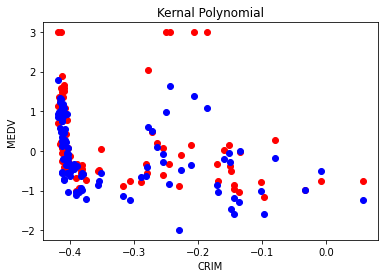

     pcost       dcost       gap    pres   dres
 0: -6.5043e+01 -1.9050e+03  9e+03  3e+00  4e-13
 1: -3.1221e+00 -1.2034e+03  1e+03  6e-14  6e-13
 2: -3.4342e+01 -1.7959e+02  1e+02  2e-13  6e-13
 3: -7.2076e+01 -1.2462e+02  5e+01  7e-14  5e-13
 4: -8.7302e+01 -1.0496e+02  2e+01  1e-15  4e-13
 5: -9.1937e+01 -9.9696e+01  8e+00  1e-13  4e-13
 6: -9.4310e+01 -9.6981e+01  3e+00  9e-14  5e-13
 7: -9.5065e+01 -9.6131e+01  1e+00  3e-14  4e-13
 8: -9.5416e+01 -9.5736e+01  3e-01  7e-14  5e-13
 9: -9.5503e+01 -9.5640e+01  1e-01  2e-14  4e-13
10: -9.5536e+01 -9.5604e+01  7e-02  1e-13  4e-13
11: -9.5560e+01 -9.5578e+01  2e-02  1e-13  5e-13
12: -9.5567e+01 -9.5570e+01  2e-03  7e-14  5e-13
13: -9.5568e+01 -9.5568e+01  4e-05  7e-14  6e-13
Optimal solution found.


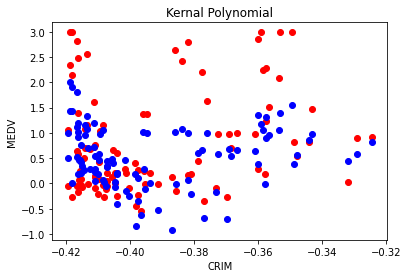

     pcost       dcost       gap    pres   dres
 0: -2.5919e+01 -1.5905e+03  6e+03  2e+00  2e-13
 1:  5.8300e+00 -9.0571e+02  9e+02  1e-15  3e-13
 2: -2.5789e+01 -1.3851e+02  1e+02  8e-14  3e-13
 3: -6.4085e+01 -9.8065e+01  3e+01  5e-14  3e-13
 4: -7.5292e+01 -8.8688e+01  1e+01  1e-13  3e-13
 5: -8.0353e+01 -8.4085e+01  4e+00  4e-14  2e-13
 6: -8.1604e+01 -8.3012e+01  1e+00  6e-14  2e-13
 7: -8.2051e+01 -8.2591e+01  5e-01  8e-14  2e-13
 8: -8.2256e+01 -8.2396e+01  1e-01  2e-14  2e-13
 9: -8.2302e+01 -8.2349e+01  5e-02  4e-14  2e-13
10: -8.2315e+01 -8.2337e+01  2e-02  1e-14  2e-13
11: -8.2321e+01 -8.2331e+01  1e-02  1e-13  2e-13
12: -8.2326e+01 -8.2326e+01  4e-04  1e-13  2e-13
13: -8.2326e+01 -8.2326e+01  4e-06  6e-14  3e-13
Optimal solution found.


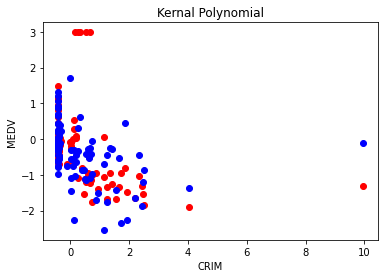

     pcost       dcost       gap    pres   dres
 0: -7.4137e+01 -1.9365e+03  1e+04  3e+00  2e-13
 1: -5.7646e+00 -1.2341e+03  1e+03  8e-14  2e-13
 2: -3.6153e+01 -2.2036e+02  2e+02  1e-13  2e-13
 3: -7.8925e+01 -1.2368e+02  4e+01  3e-13  2e-13
 4: -9.4635e+01 -1.0554e+02  1e+01  4e-14  2e-13
 5: -9.7511e+01 -1.0244e+02  5e+00  1e-13  2e-13
 6: -9.9142e+01 -1.0065e+02  2e+00  3e-14  2e-13
 7: -9.9676e+01 -1.0008e+02  4e-01  2e-14  2e-13
 8: -9.9807e+01 -9.9934e+01  1e-01  2e-14  2e-13
 9: -9.9856e+01 -9.9882e+01  3e-02  3e-14  2e-13
10: -9.9868e+01 -9.9869e+01  9e-04  4e-14  2e-13
11: -9.9869e+01 -9.9869e+01  1e-05  2e-13  2e-13
Optimal solution found.


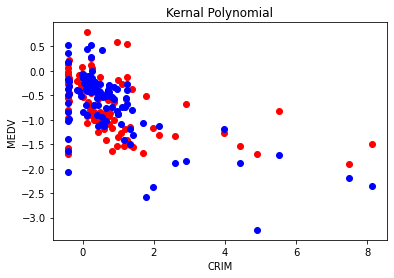

0.33464579604668093


In [47]:
k_fold_size = 101 # 5-cross validation
no_of_fold = int(len(data)/k_fold_size)
for i in range(no_of_fold):
  X_test = np.array([data[j][:-1] for j in range(i*k_fold_size,(i+1)*k_fold_size)])
  Y_test = np.array([data[j][-1] for j in range(i*k_fold_size,(i+1)*k_fold_size)])

  X_train = []
  Y_train = []
  for j in range(len(data)):
      if (j<i*k_fold_size) or (j>=(i+1)*k_fold_size):
          X_train.append(data[j][:-1])
          Y_train.append(data[j][-1])
  X_train = np.array(X_train)
  Y_train = np.array(Y_train)

  n = len(X_train)
  P = P_Matrix_polynomial(X_train, constant, d)
  q = q_matrix(Y_train, elp)
  G = G_matrix(n)
  h = h_matrix(C, n)
  A = A_matrix(n)
  b = b_matrix()

  # print("n"+str(n))
  # print("P"+str(P.shape))
  # print("q"+str(q.shape))
  # print("G"+str(G.shape))
  # print("h"+str(h.shape))
  # print("A"+str(A.shape))
  # print("b"+str(b.shape))

  P = cvxopt_matrix(P)
  q = cvxopt_matrix(q)
  G = cvxopt_matrix(G)
  h = cvxopt_matrix(h)
  A = cvxopt_matrix(A)
  b = cvxopt_matrix(b)

  sol = cvxopt_solvers.qp(P, q, G, h, A, b)
  lamda = np.array(sol['x'])
  l = int(len(lamda)/2)
  lamda_1 = lamda[0:l, :]
  lamda_2 = lamda[l:,:]
  # print(lamda_1[1][0])
  # print(lamda_1.shape)
  # print(lamda_2.shape)

  # the supp_vector array will contain all indics of vectors which are support vectors
  supp_vector = []
  for j in range(len(lamda_1)):
    temp = lamda_1[j][0]
    if temp>0 and temp<C:
      supp_vector.append(j)

  # calculation of b
  b = 0
  for i in supp_vector:
    b = b+Y_train[i]-elp-b_term_polynomial(X_train[i], n, lamda_1, lamda_2, X_train, constant, d)
  b = b/(len(supp_vector))

  Y_predict_polynomial = []
  for i in range(len(X_test)):
    temp_i = Y_predicted_polynomial(X_test[i], n, lamda_1, lamda_2, X_train, b, constant, d)
    Y_predict_polynomial.append(temp_i)
  Y_predict_polynomial = np.array(Y_predict_polynomial)
  # print(Y_predict[0])
  # print(Y_test)
  
  error = MSE(Y_predict_polynomial, Y_test, elp)
  score_polynomial.append(error)

  plt.title('Kernal Polynomial')
  plt.xlabel('CRIM')
  plt.ylabel('MEDV')
  plt.scatter(X_test[:,0], Y_test, color = 'r', label="Y_test".format('r'))
  plt.scatter(X_test[:,0], Y_predict_polynomial, color = 'b',label="Y_predicted".format('y'))
  plt.show()

score_final_polynomial = 0
for i in range(len(score_polynomial)):
  score_final_polynomial = score_final_polynomial + score_polynomial[i]
score_final_polynomial = score_final_polynomial/len(score_polynomial)
print(score_final_polynomial)